In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv("./Datasets/ml-32m/ratings.csv")
movies = pd.read_csv("./Datasets/ml-32m/movies.csv")

<h2>Exploratory data</h2>

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

In [6]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movie Id: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 32000204
Number of unique movie Id: 84432
Number of unique users: 200948
Average number of ratings per user: 159.25
Average number of ratings per movie: 379.01


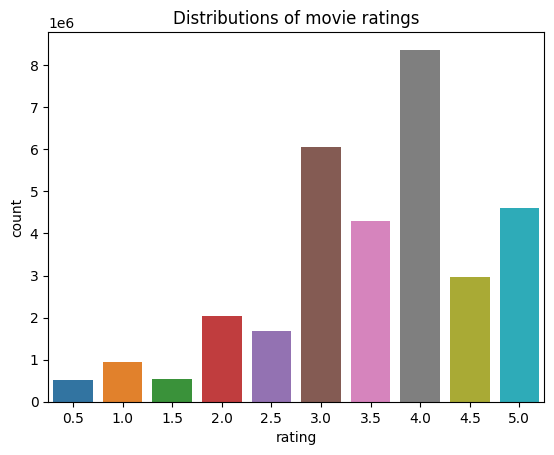

In [7]:
sns.countplot(x='rating', data=ratings)
plt.title("Distributions of movie ratings")
plt.show()

In [8]:
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")

Mean global rating: 3.54


In [9]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

Mean rating per user: 3.7


<h2>Movie mana yang lebih sering diberikan rating</h2>

In [10]:
ratings['movieId'].value_counts()

318       102929
356       100296
296        98409
2571       93808
593        90330
           ...  
288825         1
288467         1
287221         1
284087         1
274343         1
Name: movieId, Length: 84432, dtype: int64

In [11]:
movie_rating = ratings.merge(movies, on='movieId')


In [12]:
# Top 10 most rated movies
movie_rating['title'].value_counts()[0:10]

Shawshank Redemption, The (1994)                             102929
Forrest Gump (1994)                                          100296
Pulp Fiction (1994)                                           98409
Matrix, The (1999)                                            93808
Silence of the Lambs, The (1991)                              90330
Star Wars: Episode IV - A New Hope (1977)                     85010
Fight Club (1999)                                             77332
Jurassic Park (1993)                                          75233
Schindler's List (1993)                                       73849
Lord of the Rings: The Fellowship of the Ring, The (2001)     73122
Name: title, dtype: int64

<h2>Movie mana yang jarang diberikan rating</h2>

In [13]:
lowest_rating = movie_rating['rating'].idxmin()
movies[movies['movieId'] == lowest_rating]

,movieId,title,genres
218,220,Castle Freak (1995),Horror


In [14]:
highest_rating = movie_rating['rating'].idxmax()
movies[movies['movieId'] == highest_rating]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
ratings[ratings['movieId'] == highest_rating]

,userId,movieId,rating,timestamp
559,10,1,2.5,1169265231
1219,11,1,3.0,850085076
1733,17,1,4.0,1027305751
1957,19,1,3.0,974704488
2004,20,1,5.0,1553184230
...,...,...,...,...
31998476,200938,1,4.5,1305857133
31998887,200943,1,3.5,1274577920
31999478,200944,1,4.0,1454247529
31999907,200947,1,4.0,1495973163


<h2>Bayesian Average</h2>
<p>Kita menggunakan bayesian average untuk mengitung rating movie</p>

In [16]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,68997,3.897438
2,28904,3.275758
3,13134,3.139447
4,2806,2.845331
5,13154,3.059602


In [17]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_average(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_avg, 3)

In [18]:
toy_story = ratings[ratings['movieId'] == 1]['rating']
bayesian_average(toy_story)


3.893

In [19]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_average).reset_index()

In [20]:
bayesian_avg_ratings.columns = ['movieId', 'bayesian_average']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [21]:
movie_stats.head()

,movieId,count,mean,bayesian_average
0,1,68997,3.897438,3.893
1,2,28904,3.275758,3.272
2,3,13134,3.139447,3.136
3,4,2806,2.845331,2.864
4,5,13154,3.059602,3.058


In [22]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])

In [23]:
movie_stats.sort_values(by='bayesian_average', ascending=True)

,movieId,count,mean,bayesian_average,title
3495,3593,5010,1.567265,1.668,Battlefield Earth (2000)
4670,4775,757,1.128798,1.755,Glitter (2001)
6465,6587,838,1.204057,1.765,Gigli (2003)
11353,50798,1492,1.463137,1.775,Epic Movie (2007)
9607,31698,832,1.220553,1.779,Son of the Mask (2005)
...,...,...,...,...,...
49,50,67750,4.265070,4.258,"Usual Suspects, The (1995)"
58698,202439,11670,4.312254,4.271,Parasite (2019)
39306,159817,2948,4.444369,4.280,Planet Earth (2006)
840,858,66440,4.317030,4.310,"Godfather, The (1972)"


In [24]:
movie_stats.to_csv("movie_stats.csv")

<h2>Sekarang kita fokus dengan genre movie</h2>

In [25]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [26]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are: {len(genre_frequency)} genres")

genre_frequency

There are: 20 genres


Counter({'Drama': 34175,
         'Comedy': 23124,
         'Thriller': 11823,
         'Romance': 10369,
         'Action': 9668,
         'Documentary': 9363,
         'Horror': 8654,
         '(no genres listed)': 7080,
         'Crime': 6976,
         'Adventure': 5402,
         'Sci-Fi': 4907,
         'Animation': 4617,
         'Children': 4520,
         'Mystery': 4013,
         'Fantasy': 3851,
         'War': 2325,
         'Western': 1696,
         'Musical': 1059,
         'Film-Noir': 353,
         'IMAX': 195})

In [27]:
print(F"Most common genre: {genre_frequency.most_common(5)}")

Most common genre: [('Drama', 34175), ('Comedy', 23124), ('Thriller', 11823), ('Romance', 10369), ('Action', 9668)]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Romance'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Documentary'),
  Text(6, 0, 'Horror'),
  Text(7, 0, '(no genres listed)'),
  Text(8, 0, 'Crime'),
  Text(9, 0, 'Adventure'),
  Text(10, 0, 'Sci-Fi'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Children'),
  Text(13, 0, 'Mystery'),
  Text(14, 0, 'Fantasy'),
  Text(15, 0, 'War'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'Musical'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, 'IMAX')])

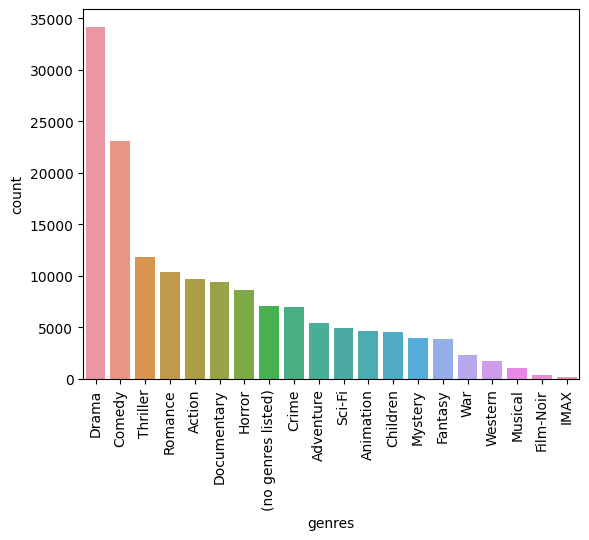

In [28]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genres', 'count']

sns.barplot(x='genres', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)

<h2>Preprocessing data</h2>

In [29]:
from scipy.sparse import csr_matrix

In [30]:
# karena Sparsity kurang dari 1.0% maka dibutuhkan filter
# Jika movie memiliki jumlah rating  < 50 drop
# Jika user melakukan rating < 50 kali drop
min_movie_ratings = 50
min_user_ratings = 50

# Filter movies
filtered_movie_ids = ratings['movieId'].value_counts()
filtered_movie_ids = filtered_movie_ids[filtered_movie_ids >= min_movie_ratings].index

# Filter users
filtered_user_ids = ratings['userId'].value_counts()
filtered_user_ids = filtered_user_ids[filtered_user_ids >= min_user_ratings].index

filtered_ratings = ratings[
    ratings['movieId'].isin(filtered_movie_ids) & 
    ratings['userId'].isin(filtered_user_ids)
]

filtered_ratings

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [31]:
def create_x(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df['userId']), list(range(M))))
    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userId'])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df['movieId'])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df['rating'], (user_index, item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_x(filtered_ratings)


In [32]:
X.shape

(128344, 16034)

<h2>Evaluating Sparsity</h2>

In [33]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix Sparsity: {round(sparsity*100, 2)}%")

# 0.19% terlalu kecil minimal 1.0%
# data ratings and movies must be filltered and rebuild X

Matrix Sparsity: 1.42%


<h2>Cold Start problem</h2>

In [34]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

128344

In [35]:
print(f"most active user rated {n_ratings_per_user.max()} movies")
print(f"least active user rated {n_ratings_per_user.min()} movies")

most active user rated 11941 movies
least active user rated 10 movies


In [36]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

16034

In [37]:
print(f"most rated movie has {n_ratings_per_movie.max()} rating(s)")
print(f"least rated movie has {n_ratings_per_movie.min()} rating(s)")

most rated movie has 80039 rating(s)
least rated movie has 37 rating(s)


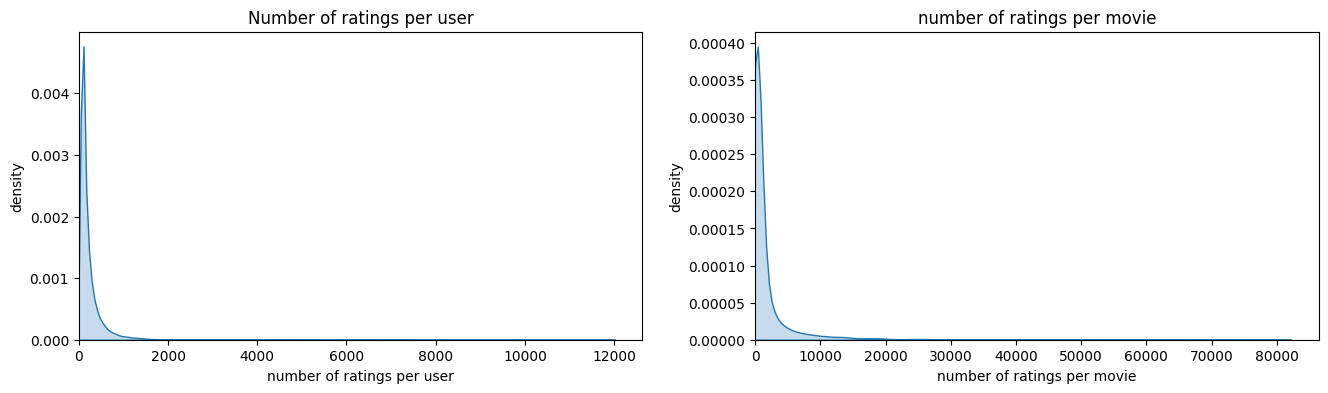

In [38]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of ratings per user")
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("number of ratings per movie")
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()


<h2>Recommendation with K-Nearest Neighbors</h2>

In [39]:
from sklearn.neighbors import NearestNeighbors

In [40]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)

    knN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    knN.fit(X)
    neighbour = knN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    
    neighbour_ids.pop(0)
    return neighbour_ids

In [41]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 356, 260, 480, 1270, 364, 588, 1210, 1196]

<h2>Untuk metric</h2>
<ul>
<li>cosine</li>
<li>euclidean</li>
<li>manhattan</li>
</ul>

In [42]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
# movie_titles

movie_id = 1
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Becuase you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Becuase you watched Toy Story (1995):
Toy Story 2 (1999)
Aladdin (1992)
Lion King, The (1994)
Bug's Life, A (1998)
Monsters, Inc. (2001)
Men in Black (a.k.a. MIB) (1997)
Independence Day (a.k.a. ID4) (1996)
Beauty and the Beast (1991)
Shrek (2001)


<h2>Berdasarkan hasil KNN</h2>
<p>KNN dengan metric euclidean menghasilkan rekomendasi yang lebih bagus dibandingkan dengan metric cosine</p>

<h2>Handling Cold Start problem</h2>

In [43]:
n_movies = movies['movieId'].nunique()
n_movies

87585

In [44]:
# Encoding one hot encoder
genres = set(g for G in movies['genres'] for g in G)
# genres
for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

In [45]:
movies_genres = movies.drop(columns=['movieId', 'genres'])

In [46]:
movies_genres = movies_genres.drop(columns='title')

In [47]:
movies_genres

,Film-Noir,Documentary,(no genres listed),Romance,Action,Animation,Horror,Crime,War,Drama,Mystery,Thriller,Comedy,Musical,Fantasy,Western,Adventure,Children,IMAX,Sci-Fi
0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87580,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
87581,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
87582,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
87583,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
cosine_sim = cosine_similarity(movies_genres, movies_genres)
print(f"Dimension of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimension of our genres cosine similarity matrix: (87585, 87585)


In [50]:
# cosine_sim[0]

<h2>Create a movie finder</h2>

In [51]:
from rapidfuzz import process, fuzz

In [52]:
def movie_finder(title):
    all_title = movies['title'].tolist()
    closest_match = process.extractOne(title, all_title, scorer=fuzz.ratio)
    return closest_match[0]

In [53]:
search_title = movie_finder('Jumanji')
search_title 

'Jumanji (1995)'

In [54]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[search_title]
print(f"Movie Index for Jumanji: {idx}")

Movie Index for Jumanji: 1


In [55]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1: (n_recommendations+1)]
sim_scores

[(59, 1.0000000000000002),
 (124, 1.0000000000000002),
 (986, 1.0000000000000002),
 (1954, 1.0000000000000002),
 (2003, 1.0000000000000002),
 (2071, 1.0000000000000002),
 (2072, 1.0000000000000002),
 (2308, 1.0000000000000002),
 (4791, 1.0000000000000002),
 (9559, 1.0000000000000002)]

In [56]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[59, 124, 986, 1954, 2003, 2071, 2072, 2308, 4791, 9559]

In [57]:
print(f"Because you watch {search_title}:")
movies['title'].iloc[similar_movies]

Because you watch Jumanji (1995):


59                     Indian in the Cupboard, The (1995)
124                     NeverEnding Story III, The (1994)
986                       Escape to Witch Mountain (1975)
1954            Darby O'Gill and the Little People (1959)
2003                                  Return to Oz (1985)
2071                        NeverEnding Story, The (1984)
2072    NeverEnding Story II: The Next Chapter, The (1...
2308                        Santa Claus: The Movie (1985)
4791    Harry Potter and the Sorcerer's Stone (a.k.a. ...
9559                            Magic in the Water (1995)
Name: title, dtype: object

In [58]:
movies.head()

,movieId,title,genres,Film-Noir,Documentary,(no genres listed),Romance,Action,Animation,Horror,...,Mystery,Thriller,Comedy,Musical,Fantasy,Western,Adventure,Children,IMAX,Sci-Fi
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,1,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [59]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: (n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [60]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
2203                                       Antz (1998)
3021                                Toy Story 2 (1999)
3654    Adventures of Rocky and Bullwinkle, The (2000)
3913                  Emperor's New Groove, The (2000)
4781                             Monsters, Inc. (2001)
Name: title, dtype: object


<h2>Dimensionality Reduction with Matrix factorization</h2>

In [61]:
from sklearn.decomposition import TruncatedSVD

In [62]:
# n_components merupakan hyper parameter
# Semakin kecil n_component semakin compact matrix sehingga accuracy prediction berkurang.
svd = TruncatedSVD(n_components=30, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(16034, 30)

In [63]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Lion King, The (1994)
Toy Story 2 (1999)
Aladdin (1992)
Men in Black (a.k.a. MIB) (1997)
Shrek (2001)
Back to the Future (1985)
Monsters, Inc. (2001)
Groundhog Day (1993)
Jurassic Park (1993)


In [64]:
import pickle

In [65]:
# with open('svd_modelv2.pkl', 'wb') as f:
#     pickle.dump(svd, f)

In [66]:
# np.save('Q_matrix.npy', Q)

In [67]:
# with open('movie_inv_mapper.pkl', 'wb') as f:
#     pickle.dump(movie_inv_mapper, f)

# with open('user_inv_mapper.pkl', 'wb') as f:
#     pickle.dump(user_inv_mapper, f)


In [68]:
# with open("cosine_simv2.pkl","wb") as f:
#     pickle.dump(cosine_sim, f)

In [69]:

# with open('movie_titles.pkl', 'wb') as f:
#     pickle.dump(movie_titles, f)